# Demand Forecasting using LSTM in Keras

**This notebook applies LSTM Network to a retail dataset that has weak seasonality. There are 3 versions of LSTM's.
I have also used a holiday dataset to generate additional features such as type of holiday, weekend and also date features like day, month and year. The multiple flavors of LSTM's are
    1.Single layer (model_k1)
    2.Stacked LSTM (model_k2)
    3.Multiple feature dataset with prior time values as additional features (model_k3)

In [448]:
import pandas as pd
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import matplotlib.pyplot as plt

#Read Time Series Data
demand=pd.read_csv('demand.csv',delimiter=',',error_bad_lines=False)

In [449]:
#Read Holiday File
holiday=pd.read_csv('HOLIDAY.csv',delimiter=',',error_bad_lines=False)
holiday[:5]

,DATEDIMID,DAY_OF_THE_WEEK,HOLIDAY
0,20120101,SUNDAY,New Year's Day
1,20120102,MONDAY,New Year Day+1
2,20120103,TUESDAY,New Year Day+2
3,20120104,WEDNESDAY,None
4,20120105,THURSDAY,None


In [450]:
#Convert any date in input data to Python Date object
demand['NEWDATE']=pd.to_datetime(demand.NEWDATE.apply(str))
holiday['DATEDIMID']=pd.to_datetime(holiday.DATEDIMID.apply(str))

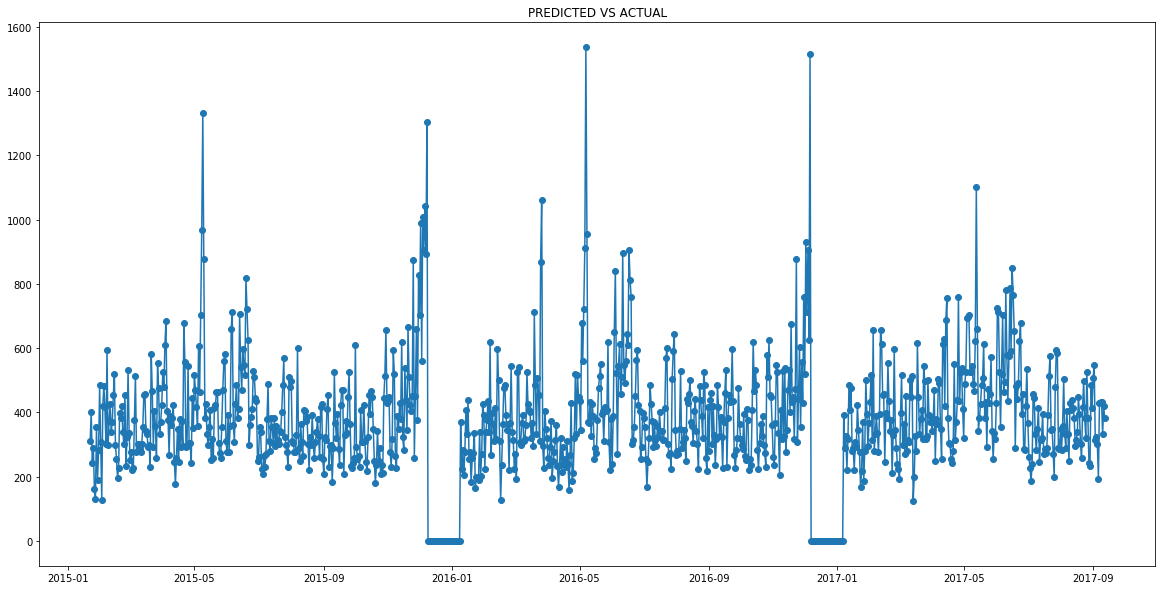

In [451]:
#Explore Time Series
plt.figure(figsize=(20,10))
plt.plot_date(demand['NEWDATE'],demand['UNITS'],linestyle='-')
plt.title("PREDICTED VS ACTUAL")
plt.show()

In [452]:
#Generate Day, Month, Year features
demand1 = demand.join(pd.DataFrame({'year' : demand.NEWDATE.dt.year, 'month' : demand.NEWDATE.dt.month, 'day' : demand.NEWDATE.dt.day}))

In [453]:
#Join with holidat dataser
featureset=demand1.merge(holiday,left_on=['NEWDATE'],right_on=['DATEDIMID'],how='left')

In [454]:
#Merged Dataset
featureset[:5]

,UNITS,NEWDATE,day,month,year,DATEDIMID,DAY_OF_THE_WEEK,HOLIDAY
0,312.511011,2015-01-22,22,1,2015,2015-01-22,THURSDAY,None
1,400.400756,2015-01-23,23,1,2015,2015-01-23,FRIDAY,None
2,243.048040,2015-01-24,24,1,2015,2015-01-24,SATURDAY,None
3,290.361297,2015-01-25,25,1,2015,2015-01-25,SUNDAY,None
4,163.152387,2015-01-26,26,1,2015,2015-01-26,MONDAY,None


In [455]:
#Replace nulls with 0
featureset=featureset.fillna(0)

In [456]:
#Holiday Feature Engineering - Encode Holiday Features (From categorical to numeric indexes)
featureset['HOLIDAY'] = featureset.HOLIDAY.map( lambda x: 'None' if (x == '0' or x == 0)else x)

from sklearn.preprocessing import LabelEncoder
enc=LabelEncoder()

enc.fit(featureset['DAY_OF_THE_WEEK'])
featureset['WEEKDAY'] = enc.transform(featureset['DAY_OF_THE_WEEK'])

enc.fit(featureset['HOLIDAY'])
featureset['HOLIDAY'] = enc.transform(featureset['HOLIDAY'])

featureset=featureset.drop(['DATEDIMID','DAY_OF_THE_WEEK'], axis=1)
featureset[:3]

#Our Final dataset

,UNITS,NEWDATE,day,month,year,HOLIDAY,WEEKDAY
0,312.511011,2015-01-22,22,1,2015,50,4
1,400.400756,2015-01-23,23,1,2015,50,0
2,243.048040,2015-01-24,24,1,2015,50,2


In [457]:
#LSTM for Regression Using the Window Method. Please notice the window dataset below it has previous time steps appended as features

for obs in range(1,365):
    featureset["T_" + str(obs)] = featureset.UNITS.shift(obs)
featureset=featureset.fillna(0)

In [458]:
featureset[:3]

,UNITS,NEWDATE,day,month,year,HOLIDAY,WEEKDAY,T_1,T_2,T_3,...,T_355,T_356,T_357,T_358,T_359,T_360,T_361,T_362,T_363,T_364
0,312.511011,2015-01-22,22,1,2015,50,4,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,400.400756,2015-01-23,23,1,2015,50,0,312.511011,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,243.048040,2015-01-24,24,1,2015,50,2,400.400756,312.511011,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [459]:
m,n=featureset.shape
m,n

(964, 371)

In [460]:
#Select an arbitrary date range for forecasting
trainset=featureset.loc[featureset['NEWDATE']<='2017-04-01']
valset=featureset.loc[(featureset['NEWDATE']>='2017-04-01') & (featureset['NEWDATE']<='2017-04-30')]
testset=featureset.loc[featureset['NEWDATE']>='2017-05-01']

trainsetprescale=trainset.drop(columns=['NEWDATE'])
valsetprescale=valset.drop(columns=['NEWDATE'])
testsetprescale=testset.drop(columns=['NEWDATE'])

In [461]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler
scaler = StandardScaler()

Xtrain_scaled = scaler.fit_transform(trainsetprescale.drop(columns=['UNITS']))
Ytrain_scaled = scaler.fit_transform(trainsetprescale[['UNITS']])

Xtest_scaled = scaler.fit_transform(testsetprescale.drop(columns=['UNITS']))
Ytest_scaled = scaler.fit_transform(testsetprescale[['UNITS']])

Xval_scaled = scaler.fit_transform(valsetprescale.drop(columns=['UNITS']))
Yval_scaled = scaler.fit_transform(valsetprescale[['UNITS']])

In [462]:
#LSTM expects a 3D dataset as inout vector. 
#Input_X = X.reshape(a,b,c): 'a' training instances contains b rows each, each row containing c features
#In our case: 964 training instances containing 1 row each and each row has 34 features.
train_lstm = Xtrain_scaled.reshape((Xtrain_scaled.shape[0], 1, Xtrain_scaled.shape[1]))
test_lstm = Xtest_scaled.reshape((Xtest_scaled.shape[0], 1, Xtest_scaled.shape[1]))
val_lstm = Xval_scaled.reshape((Xval_scaled.shape[0], 1, Xval_scaled.shape[1]))
train_lstm

array([[[ 0.70099678, -1.46856832, -1.02644347, ..., -0.87172396,
         -0.86978535, -0.86808437]],

       [[ 0.81424343, -1.46856832, -1.02644347, ..., -0.87172396,
         -0.86978535, -0.86808437]],

       [[ 0.92749008, -1.46856832, -1.02644347, ..., -0.87172396,
         -0.86978535, -0.86808437]],

       ...,

       [[ 1.60696999, -0.89783494,  1.9759506 , ...,  0.27670195,
          0.55193985,  0.67984004]],

       [[ 1.72021664, -0.89783494,  1.9759506 , ...,  0.17531558,
          0.27822964,  0.55299805]],

       [[-1.67718292, -0.61246826,  1.9759506 , ...,  0.43010259,
          0.17687955,  0.27941159]]])

In [463]:
Xtrain_scaled.shape
train_lstm.shape

(800, 1, 369)

In [464]:
#LSTM with single layer window method
model_k1 = Sequential()
model_k1.add(LSTM(1, input_shape=(1,Xtrain_scaled.shape[1])))
model_k1.add(Dense(1))
model_k1.compile(loss='mean_squared_error', optimizer='adam')

In [465]:
#LSTM with multiple layers Window method
model_k2 = Sequential()
model_k2.add(LSTM(30,return_sequences=True, input_shape=(1,Xtrain_scaled.shape[1])))
model_k2.add(LSTM(30))
model_k2.add(Dense(1))

model_k2.compile(loss='mean_squared_error', optimizer='adam')

In [466]:
#LSTM with multiple layers Time Step method


model_k3 = Sequential()
model_k3.add(LSTM(4,return_sequences=True, input_shape=(Xtrain_scaled.shape[1],1)))
model_k3.add(LSTM(4))
model_k3.add(Dense(1))

model_k3.compile(loss='mean_squared_error', optimizer='adam')

In [467]:
Xtrain_scaled

array([[ 0.70099678, -1.46856832, -1.02644347, ..., -0.87172396,
        -0.86978535, -0.86808437],
       [ 0.81424343, -1.46856832, -1.02644347, ..., -0.87172396,
        -0.86978535, -0.86808437],
       [ 0.92749008, -1.46856832, -1.02644347, ..., -0.87172396,
        -0.86978535, -0.86808437],
       ...,
       [ 1.60696999, -0.89783494,  1.9759506 , ...,  0.27670195,
         0.55193985,  0.67984004],
       [ 1.72021664, -0.89783494,  1.9759506 , ...,  0.17531558,
         0.27822964,  0.55299805],
       [-1.67718292, -0.61246826,  1.9759506 , ...,  0.43010259,
         0.17687955,  0.27941159]])

In [468]:
#Train LSTM. Choose(model_k1,model_k2,model_k3 to fine tune)
history = model_k3.fit(train_lstm, Ytrain_scaled, validation_data=(val_lstm, Yval_scaled),
epochs=100, batch_size=4, verbose=2)

Train on 800 samples, validate on 30 samples
Epoch 1/100
 - 5s - loss: 0.9064 - val_loss: 0.9458
Epoch 2/100
 - 1s - loss: 0.7151 - val_loss: 0.9249
Epoch 3/100
 - 1s - loss: 0.5871 - val_loss: 0.8810
Epoch 4/100
 - 1s - loss: 0.5006 - val_loss: 0.9092
Epoch 5/100
 - 1s - loss: 0.4385 - val_loss: 0.8935
Epoch 6/100
 - 1s - loss: 0.3765 - val_loss: 0.9072
Epoch 7/100
 - 1s - loss: 0.3371 - val_loss: 0.9041
Epoch 8/100
 - 1s - loss: 0.3026 - val_loss: 0.9803
Epoch 9/100
 - 1s - loss: 0.2595 - val_loss: 1.0222
Epoch 10/100
 - 1s - loss: 0.2340 - val_loss: 1.0021
Epoch 11/100
 - 1s - loss: 0.2086 - val_loss: 1.0513
Epoch 12/100
 - 1s - loss: 0.1891 - val_loss: 1.0713
Epoch 13/100
 - 1s - loss: 0.1660 - val_loss: 1.1010
Epoch 14/100
 - 1s - loss: 0.1540 - val_loss: 1.0996
Epoch 15/100
 - 1s - loss: 0.1507 - val_loss: 1.1530
Epoch 16/100
 - 1s - loss: 0.1342 - val_loss: 1.2086
Epoch 17/100
 - 1s - loss: 0.1242 - val_loss: 1.0952
Epoch 18/100
 - 1s - loss: 0.1189 - val_loss: 1.2010
Epoch 19/1

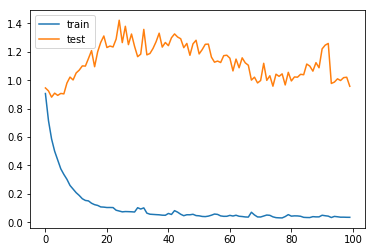

In [469]:
#Plot Loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

In [470]:
#Predict and merge predictions with original 
testPredict = model_k3.predict(test_lstm)
testPredict=scaler.inverse_transform([testPredict])
Ytest=scaler.inverse_transform(Ytest_scaled)
testset['Predicted']= testPredict[0]

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [471]:
testset[:4]

,UNITS,NEWDATE,day,month,year,HOLIDAY,WEEKDAY,T_1,T_2,T_3,...,T_356,T_357,T_358,T_359,T_360,T_361,T_362,T_363,T_364,Predicted
829,321.479318,2017-05-01,1,5,2017,50,1,412.321142,539.765859,525.304532,...,369.396273,953.719391,1537.000000,912.000000,723.000000,558.924215,677.000000,344.245021,435.644359,518.413330
830,489.000000,2017-05-02,2,5,2017,50,5,321.479318,412.321142,539.765859,...,366.235778,369.396273,953.719391,1537.000000,912.000000,723.000000,558.924215,677.000000,344.245021,486.372406
831,524.772363,2017-05-03,3,5,2017,50,6,489.000000,321.479318,412.321142,...,431.299542,366.235778,369.396273,953.719391,1537.000000,912.000000,723.000000,558.924215,677.000000,644.264709
832,695.000000,2017-05-04,4,5,2017,50,4,524.772363,489.000000,321.479318,...,325.618537,431.299542,366.235778,369.396273,953.719391,1537.000000,912.000000,723.000000,558.924215,600.932068


In [472]:
#OVERALL RMSE
from math import sqrt
from sklearn.metrics import mean_squared_error
RMSE = (sqrt(mean_squared_error(testset['UNITS'],
                                  testset['Predicted'])))
RMSE

128.5447082750624

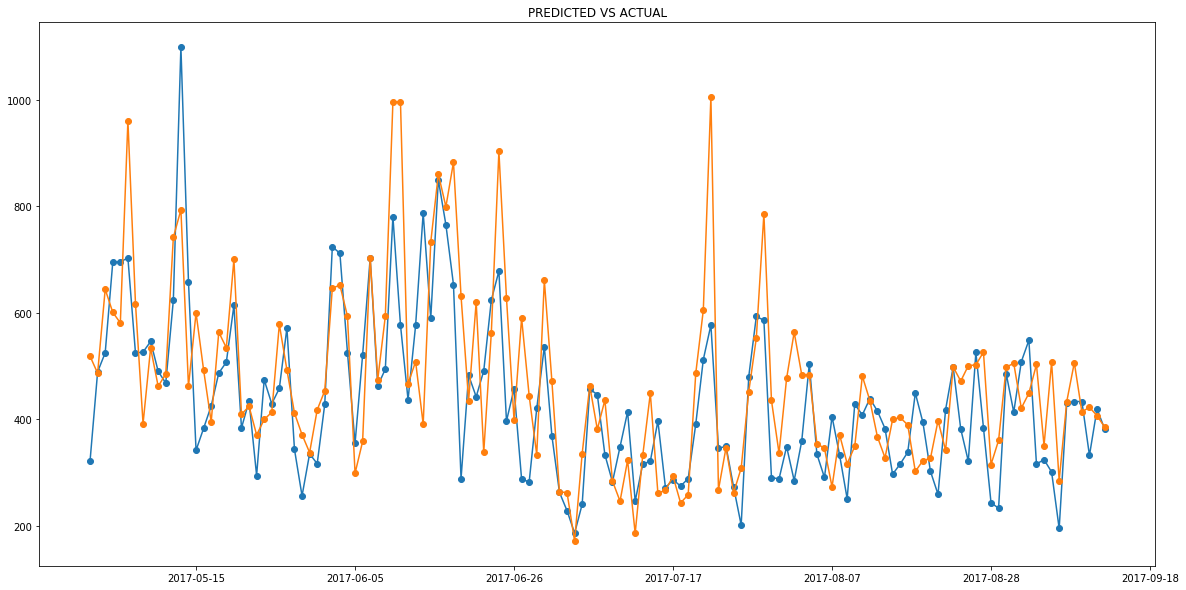

In [473]:
#Plot random forest predictions

plt.figure(figsize=(20,10))
plt.plot_date(testset['NEWDATE'],testset['UNITS'],linestyle='-')
plt.plot_date(testset['NEWDATE'],testset['Predicted'],linestyle='-')
plt.title("PREDICTED VS ACTUAL")
plt.show()
    

In [474]:
#I tried multiple parameters on this dataset. This data set has weak seasonality and 
#you will not see the same accuracy as you would in a simple sequence training problem. But this just goes to prove that
#LSTM can learn complex real datasets with low seasonality and do a good job at mimicing reality.